## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
from pathlib import Path

def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for candidate in [start, *start.parents]:
        if (candidate / 'data').exists() and (candidate / 'notebooks').exists():
            return candidate
    return start

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / 'data'
VIS_DIR = PROJECT_ROOT / 'visualizations'
REPORTS_DIR = PROJECT_ROOT / 'reports'
MODELS_DIR = PROJECT_ROOT / 'models'

for d in (DATA_DIR, VIS_DIR, REPORTS_DIR, MODELS_DIR):
    d.mkdir(parents=True, exist_ok=True)

def write_text_utf8(path: Path, text: str) -> None:
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(text, encoding='utf-8', newline='\n')

print(f"Project root: {PROJECT_ROOT}")

Project root: C:\Projects\FUTURE_ML_01


In [3]:
import builtins
from pathlib import Path

_open_original = builtins.open

def open_utf8(file, mode='r', *args, **kwargs):
    # Keep binary mode behavior unchanged
    if 'b' in mode:
        return _open_original(file, mode, *args, **kwargs)

    # Ensure text mode defaults to UTF-8 unless caller explicitly sets encoding
    if 'encoding' not in kwargs:
        kwargs['encoding'] = 'utf-8'
    if 'newline' not in kwargs:
        kwargs['newline'] = '\n'

    return _open_original(file, mode, *args, **kwargs)

builtins.open = open_utf8
print("Unicode-safe open() enabled (default UTF-8 for text files).")

Unicode-safe open() enabled (default UTF-8 for text files).


## 2. Load Featured Dataset

In [4]:
# Load the dataset with engineered features
df = pd.read_csv('../data/featured_superstore.csv')

# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['Order Date'].min()} to {df['Order Date'].max()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (9994, 35)

Date range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00

First few rows:


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,year,month,day,day_of_week,quarter,week_of_year,sales_lag_1,sales_lag_7,sales_lag_30,sales_rolling_7,sales_rolling_30,is_weekend,is_month_start,is_month_end
0,7981,CA-2014-103800,2014-01-03,2014-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512,2014,1,3,4,1,1,NaN,NaN,NaN,NaN,NaN,0,0,0
1,740,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717,2014,1,4,5,1,1,16.448,NaN,NaN,NaN,NaN,1,0,0
2,741,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748,2014,1,4,5,1,1,11.784,NaN,NaN,NaN,NaN,1,0,0
3,742,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870,2014,1,4,5,1,1,272.736,NaN,NaN,NaN,NaN,1,0,0
4,1760,CA-2014-141817,2014-01-05,2014-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840,2014,1,5,6,1,1,3.540,NaN,NaN,NaN,NaN,1,0,0


In [5]:
# Display column names and data types
print("Column Information:")
print(df.dtypes)
print(f"\nColumns in dataset: {df.columns.tolist()}")

Column Information:
Row ID                       int64
Order ID                    object
Order Date          datetime64[ns]
Ship Date                   object
Ship Mode                   object
Customer ID                 object
Customer Name               object
Segment                     object
Country                     object
City                        object
State                       object
Postal Code                  int64
Region                      object
Product ID                  object
Category                    object
Sub-Category                object
Product Name                object
Sales                      float64
Quantity                     int64
Discount                   float64
Profit                     float64
year                         int64
month                        int64
day                          int64
day_of_week                  int64
quarter                      int64
week_of_year                 int64
sales_lag_1                float64


## 3. Feature Selection

We'll select features that are relevant for forecasting sales. This includes:
- **Time-based features**: year, month, day, day_of_week, quarter, week_of_year
- **Lag features**: sales_lag_1, sales_lag_7, sales_lag_30
- **Rolling statistics**: sales_rolling_7, sales_rolling_30
- **Seasonality indicators**: is_weekend, is_month_start, is_month_end

We'll exclude:
- Identifier columns (Row ID, Order ID, Customer ID)
- Text columns (Customer Name, Product Name, etc.)
- The target variable (Sales) - will be separated
- The date column (Order Date) - used for splitting but not as a feature

In [6]:
# Check for missing values in the dataset
print("Missing values per column:")
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

Missing values per column:
                  Missing Count  Percentage
sales_lag_30                 30    0.300180
sales_rolling_30             29    0.290174
sales_lag_7                   7    0.070042
sales_rolling_7               6    0.060036
sales_lag_1                   1    0.010006


In [7]:
# Define feature columns for modeling
# We'll use the engineered features created in Phase 5

feature_columns = [
    # Time-based features
    'year', 'month', 'day', 'day_of_week', 'quarter', 'week_of_year',
    # Lag features
    'sales_lag_1', 'sales_lag_7', 'sales_lag_30',
    # Rolling statistics
    'sales_rolling_7', 'sales_rolling_30',
    # Seasonality indicators
    'is_weekend', 'is_month_start', 'is_month_end'
]

# Verify all feature columns exist in the dataset
available_features = [col for col in feature_columns if col in df.columns]
missing_features = [col for col in feature_columns if col not in df.columns]

print(f"Available features for modeling: {len(available_features)}")
print(available_features)

if missing_features:
    print(f"\nWarning: Missing features: {missing_features}")
else:
    print("\n✓ All planned features are available!")

Available features for modeling: 14
['year', 'month', 'day', 'day_of_week', 'quarter', 'week_of_year', 'sales_lag_1', 'sales_lag_7', 'sales_lag_30', 'sales_rolling_7', 'sales_rolling_30', 'is_weekend', 'is_month_start', 'is_month_end']

✓ All planned features are available!


## 4. Handle Missing Values from Lag Features

Lag and rolling features will have missing values at the beginning of the dataset. We need to handle these before splitting the data.

In [8]:
# Check missing values in feature columns
print("Missing values in feature columns:")
feature_missing = df[available_features].isnull().sum()
print(feature_missing[feature_missing > 0])

# Calculate percentage of missing data
total_rows = len(df)
max_missing = df[available_features].isnull().sum().max()
print(f"\nMaximum missing values: {max_missing} ({(max_missing/total_rows)*100:.2f}%)")

Missing values in feature columns:
sales_lag_1          1
sales_lag_7          7
sales_lag_30        30
sales_rolling_7      6
sales_rolling_30    29
dtype: int64

Maximum missing values: 30 (0.30%)


In [9]:
# Strategy: Drop rows with missing values in lag/rolling features
# This is appropriate because:
# 1. Missing values are only at the beginning (first 30 days)
# 2. We have 4+ years of data, losing a few rows won't impact model
# 3. Alternative (forward fill) would use future information

print(f"Original dataset size: {len(df)} rows")

# Create a clean dataset by dropping rows with any missing values in feature columns
df_clean = df.dropna(subset=available_features).copy()

print(f"Clean dataset size: {len(df_clean)} rows")
print(f"Rows removed: {len(df) - len(df_clean)} ({((len(df) - len(df_clean))/len(df))*100:.2f}%)")

# Verify no missing values remain
print(f"\nMissing values after cleaning: {df_clean[available_features].isnull().sum().sum()}")
print("✓ All missing values handled!")

Original dataset size: 9994 rows
Clean dataset size: 9964 rows
Rows removed: 30 (0.30%)

Missing values after cleaning: 0
✓ All missing values handled!


## 5. Time-Based Train-Test Split

**IMPORTANT**: For time series forecasting, we MUST use a time-based split (not random split).
- Training set: First 80% of the time period
- Test set: Last 20% of the time period

This ensures we're testing the model's ability to predict future (unseen) data.

In [10]:
# Calculate the split date (80th percentile of dates)
split_date = df_clean['Order Date'].quantile(0.8)

print(f"Split date (80th percentile): {split_date}")
print(f"\nDate range in dataset:")
print(f"  Start: {df_clean['Order Date'].min()}")
print(f"  Split: {split_date}")
print(f"  End:   {df_clean['Order Date'].max()}")

Split date (80th percentile): 2017-07-18 00:00:00

Date range in dataset:
  Start: 2014-01-13 00:00:00
  Split: 2017-07-18 00:00:00
  End:   2017-12-30 00:00:00


In [11]:
# Split data based on time
train = df_clean[df_clean['Order Date'] <= split_date].copy()
test = df_clean[df_clean['Order Date'] > split_date].copy()

print(f"Training set size: {len(train)} rows ({(len(train)/len(df_clean))*100:.2f}%)")
print(f"Test set size: {len(test)} rows ({(len(test)/len(df_clean))*100:.2f}%)")

print(f"\nTraining period: {train['Order Date'].min()} to {train['Order Date'].max()}")
print(f"Test period: {test['Order Date'].min()} to {test['Order Date'].max()}")

Training set size: 7972 rows (80.01%)
Test set size: 1992 rows (19.99%)

Training period: 2014-01-13 00:00:00 to 2017-07-18 00:00:00
Test period: 2017-07-20 00:00:00 to 2017-12-30 00:00:00


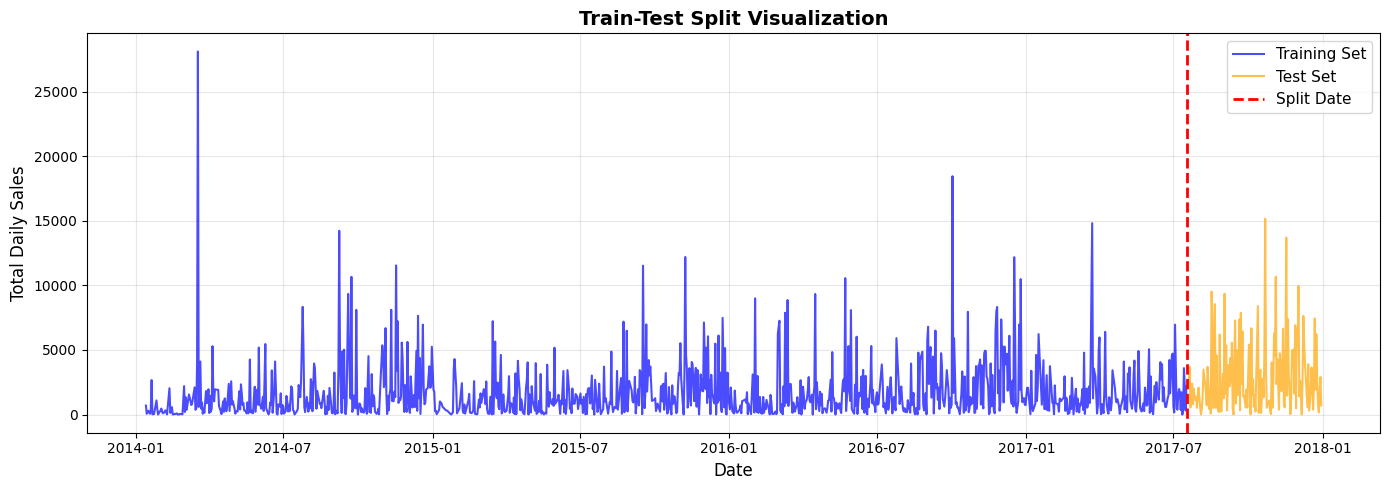

✓ Train-test split visualization saved!


In [12]:
# Visualize the train-test split
plt.figure(figsize=(14, 5))

# Aggregate sales by date for visualization
train_daily = train.groupby('Order Date')['Sales'].sum()
test_daily = test.groupby('Order Date')['Sales'].sum()

plt.plot(train_daily.index, train_daily.values, label='Training Set', color='blue', alpha=0.7)
plt.plot(test_daily.index, test_daily.values, label='Test Set', color='orange', alpha=0.7)
plt.axvline(x=split_date, color='red', linestyle='--', linewidth=2, label='Split Date')

plt.title('Train-Test Split Visualization', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Daily Sales', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Train-test split visualization saved!")

## 6. Separate Features and Target

Now we'll separate the feature matrix (X) and target variable (y) for both training and test sets.

In [13]:
# Separate features (X) and target (y) for training set
X_train = train[available_features].copy()
y_train = train['Sales'].copy()

# Separate features (X) and target (y) for test set
X_test = test[available_features].copy()
y_test = test['Sales'].copy()

print("Training set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")

print("\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

print(f"\nNumber of features: {X_train.shape[1]}")
print(f"Features: {list(X_train.columns)}")

Training set:
  X_train shape: (7972, 14)
  y_train shape: (7972,)

Test set:
  X_test shape: (1992, 14)
  y_test shape: (1992,)

Number of features: 14
Features: ['year', 'month', 'day', 'day_of_week', 'quarter', 'week_of_year', 'sales_lag_1', 'sales_lag_7', 'sales_lag_30', 'sales_rolling_7', 'sales_rolling_30', 'is_weekend', 'is_month_start', 'is_month_end']


In [14]:
# Display sample of training features
print("Sample of training features (X_train):")
print(X_train.head())

print("\nSample of training target (y_train):")
print(y_train.head())

Sample of training features (X_train):
    year  month  day  day_of_week  quarter  week_of_year  sales_lag_1  \
30  2014      1   13            0        1             3      333.999   
31  2014      1   13            0        1             3       50.940   
32  2014      1   14            1        1             3      646.740   
33  2014      1   15            2        1             3       61.960   
34  2014      1   16            3        1             3      149.950   

    sales_lag_7  sales_lag_30  sales_rolling_7  sales_rolling_30  is_weekend  \
30       19.900        16.448       329.847857        260.474100           0   
31        3.438        11.784       421.748143        281.639300           0   
32     1325.850       272.736       241.192429        274.613433           0   
33       37.408         3.540       257.269857        279.493767           0   
34       11.360        19.536       259.943000        279.844967           0   

    is_month_start  is_month_end  
30    

In [15]:
# Summary statistics for target variable
print("Target Variable (Sales) Statistics:")
print("\nTraining set:")
print(y_train.describe())

print("\nTest set:")
print(y_test.describe())

# Check if distributions are similar
print("\nDistribution comparison:")
print(f"Train mean: {y_train.mean():.2f}, Test mean: {y_test.mean():.2f}")
print(f"Train median: {y_train.median():.2f}, Test median: {y_test.median():.2f}")
print(f"Train std: {y_train.std():.2f}, Test std: {y_test.std():.2f}")

Target Variable (Sales) Statistics:

Training set:
count     7972.000000
mean       230.802675
std        632.435674
min          0.444000
25%         17.340000
50%         54.900000
75%        211.246500
max      22638.480000
Name: Sales, dtype: float64

Test set:
count     1992.000000
mean       225.633638
std        586.585695
min          0.990000
25%         17.302500
50%         54.256000
75%        199.950000
max      11199.968000
Name: Sales, dtype: float64

Distribution comparison:
Train mean: 230.80, Test mean: 225.63
Train median: 54.90, Test median: 54.26
Train std: 632.44, Test std: 586.59


## 7. Feature Scaling

We'll scale the features using StandardScaler to:
- Normalize feature ranges (mean=0, std=1)
- Improve model convergence and performance
- Ensure all features contribute equally

**IMPORTANT**: Fit the scaler ONLY on training data to avoid data leakage!

In [16]:
# Check feature statistics before scaling
print("Feature statistics BEFORE scaling:")
print("\nTraining set:")
print(X_train.describe())

Feature statistics BEFORE scaling:

Training set:
              year        month          day  day_of_week      quarter  \
count  7972.000000  7972.000000  7972.000000  7972.000000  7972.000000   
mean   2015.409433     7.262920    15.554691     3.193929     2.707100   
std       1.032262     3.343447     8.730791     2.124886     1.080331   
min    2014.000000     1.000000     1.000000     0.000000     1.000000   
25%    2015.000000     4.000000     8.000000     1.000000     2.000000   
50%    2015.000000     7.000000    16.000000     4.000000     3.000000   
75%    2016.000000    10.000000    23.000000     5.000000     4.000000   
max    2017.000000    12.000000    31.000000     6.000000     4.000000   

       week_of_year   sales_lag_1   sales_lag_7  sales_lag_30  \
count   7972.000000   7972.000000   7972.000000   7972.000000   
mean      29.618164    230.769312    230.825098    230.932153   
std       14.673555    632.423212    632.527026    632.982864   
min        1.000000    

In [17]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data ONLY
scaler.fit(X_train)

# Transform both training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for better readability (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Features scaled successfully!")
print(f"\nX_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

✓ Features scaled successfully!

X_train_scaled shape: (7972, 14)
X_test_scaled shape: (1992, 14)


In [18]:
# Verify scaling (should have mean ≈ 0 and std ≈ 1)
print("Feature statistics AFTER scaling:")
print("\nTraining set:")
print(X_train_scaled.describe())

print("\nVerification:")
print(f"Mean of all features (should be ≈ 0): {X_train_scaled.mean().mean():.6f}")
print(f"Std of all features (should be ≈ 1): {X_train_scaled.std().mean():.6f}")
print("\n✓ Scaling verified!")

Feature statistics AFTER scaling:

Training set:
               year         month           day   day_of_week       quarter  \
count  7.972000e+03  7.972000e+03  7.972000e+03  7.972000e+03  7.972000e+03   
mean  -7.986030e-16 -1.140861e-16 -1.127492e-16  1.069558e-17  1.426077e-17   
std    1.000063e+00  1.000063e+00  1.000063e+00  1.000063e+00  1.000063e+00   
min   -1.365469e+00 -1.873310e+00 -1.667158e+00 -1.503200e+00 -1.580263e+00   
25%   -3.966618e-01 -9.759763e-01 -8.653471e-01 -1.032557e+00 -6.545624e-01   
50%   -3.966618e-01 -7.864241e-02  5.100758e-02  3.793718e-01  2.711377e-01   
75%    5.721457e-01  8.186915e-01  8.528180e-01  8.500148e-01  1.196838e+00   
max    1.540953e+00  1.416914e+00  1.769173e+00  1.320658e+00  1.196838e+00   

       week_of_year   sales_lag_1   sales_lag_7  sales_lag_30  \
count  7.972000e+03  7.972000e+03  7.972000e+03  7.972000e+03   
mean  -7.130384e-17  2.139115e-17  1.604336e-17 -3.253238e-17   
std    1.000063e+00  1.000063e+00  1.000063e

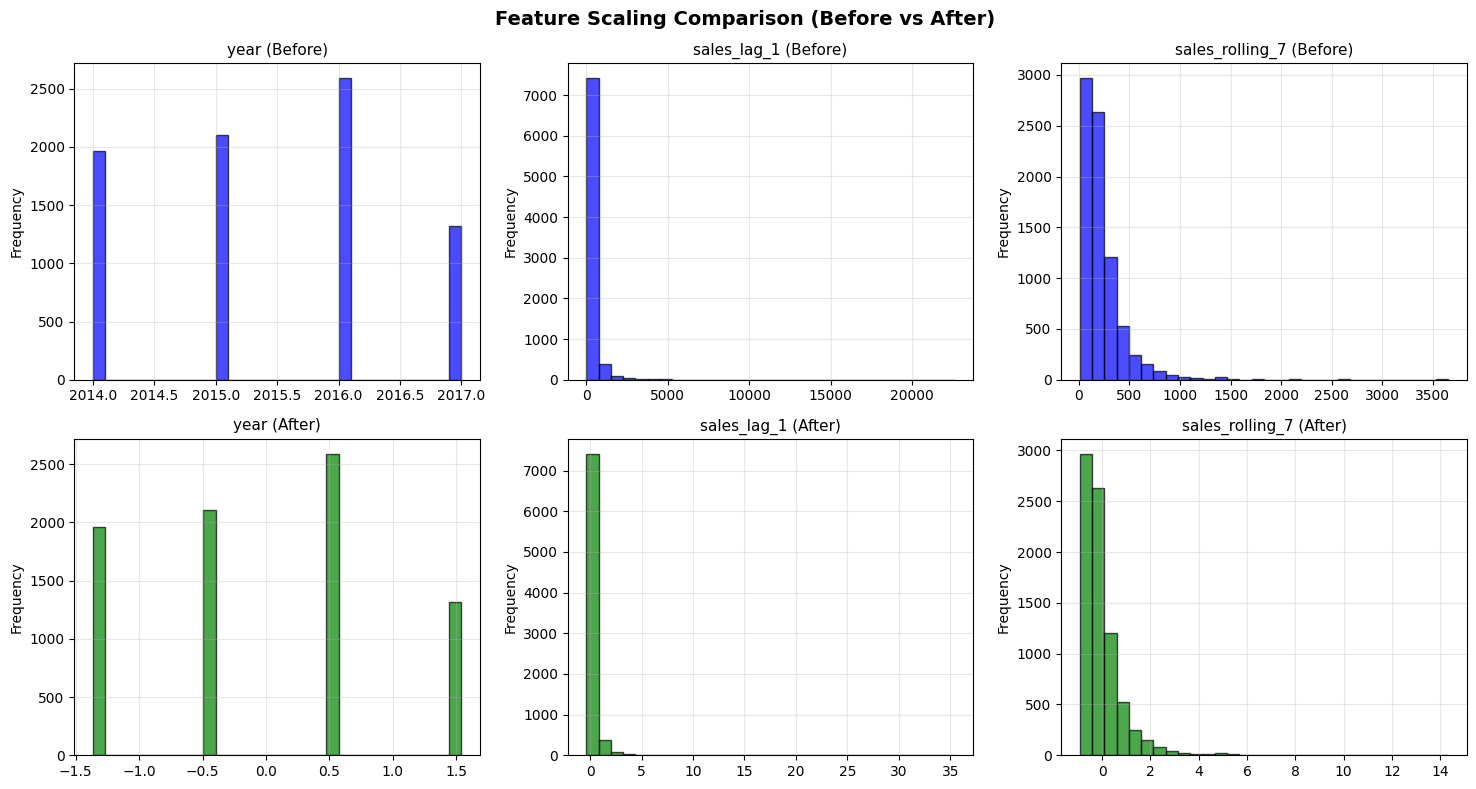

✓ Feature scaling comparison visualization saved!


In [19]:
# Visualize the effect of scaling on a few features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Feature Scaling Comparison (Before vs After)', fontsize=14, fontweight='bold')

# Select 3 features to visualize
sample_features = ['year', 'sales_lag_1', 'sales_rolling_7']

for idx, feature in enumerate(sample_features):
    # Before scaling
    axes[0, idx].hist(X_train[feature], bins=30, color='blue', alpha=0.7, edgecolor='black')
    axes[0, idx].set_title(f'{feature} (Before)', fontsize=11)
    axes[0, idx].set_ylabel('Frequency', fontsize=10)
    axes[0, idx].grid(True, alpha=0.3)
    
    # After scaling
    axes[1, idx].hist(X_train_scaled[feature], bins=30, color='green', alpha=0.7, edgecolor='black')
    axes[1, idx].set_title(f'{feature} (After)', fontsize=11)
    axes[1, idx].set_ylabel('Frequency', fontsize=10)
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/feature_scaling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature scaling comparison visualization saved!")

## 8. Save Prepared Datasets

We'll save the prepared datasets for use in the modeling phase.

In [20]:
# Save scaled datasets
X_train_scaled.to_csv('../data/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/X_test_scaled.csv', index=False)

# Save target variables
y_train.to_csv('../data/y_train.csv', index=False, header=['Sales'])
y_test.to_csv('../data/y_test.csv', index=False, header=['Sales'])

# Save unscaled versions as well (for some models that don't require scaling)
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)

# Save the date information for test set (useful for visualization later)
test[['Order Date']].to_csv('../data/test_dates.csv', index=False)
train[['Order Date']].to_csv('../data/train_dates.csv', index=False)

print("✓ All datasets saved successfully!")
print("\nFiles saved:")
print("  - X_train_scaled.csv (scaled features for training)")
print("  - X_test_scaled.csv (scaled features for testing)")
print("  - X_train.csv (unscaled features for training)")
print("  - X_test.csv (unscaled features for testing)")
print("  - y_train.csv (training target variable)")
print("  - y_test.csv (test target variable)")
print("  - train_dates.csv (training dates)")
print("  - test_dates.csv (test dates)")

✓ All datasets saved successfully!

Files saved:
  - X_train_scaled.csv (scaled features for training)
  - X_test_scaled.csv (scaled features for testing)
  - X_train.csv (unscaled features for training)
  - X_test.csv (unscaled features for testing)
  - y_train.csv (training target variable)
  - y_test.csv (test target variable)
  - train_dates.csv (training dates)
  - test_dates.csv (test dates)


In [21]:
# Save the scaler object for future use
import pickle

with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✓ Scaler object saved to models/scaler.pkl")
print("  (This will be used to scale new data during prediction)")

✓ Scaler object saved to models/scaler.pkl
  (This will be used to scale new data during prediction)


## 9. Data Preparation Summary

In [22]:
import builtins

# Some earlier cell likely shadowed `open` in the global namespace.
# Force it back to builtins.open (which we patched to default to UTF-8).
open = builtins.open

print("Forced open() to builtins.open (UTF-8 default for text mode).")

# Quick sanity check: show what encoding a new text file uses
try:
    test_path = (REPORTS_DIR / "_encoding_sanity_check.txt") if 'REPORTS_DIR' in globals() else "_encoding_sanity_check.txt"
    with open(test_path, 'w') as _f:
        print("Sanity-check write encoding:", getattr(_f, 'encoding', None))
except Exception as e:
    print("Sanity-check failed:", repr(e))

Forced open() to builtins.open (UTF-8 default for text mode).
Sanity-check write encoding: utf-8


In [23]:
# Create a comprehensive summary
summary = f"""
============================================
DATA PREPARATION SUMMARY
============================================

1. DATASET INFORMATION
   - Original dataset: featured_superstore.csv
   - Original size: {len(df)} rows
   - After cleaning: {len(df_clean)} rows
   - Rows removed: {len(df) - len(df_clean)} ({((len(df) - len(df_clean))/len(df))*100:.2f}%)
   - Date range: {df_clean['Order Date'].min()} to {df_clean['Order Date'].max()}

2. FEATURE SELECTION
   - Total features selected: {len(available_features)}
   - Features: {', '.join(available_features)}
   - Target variable: Sales

3. TRAIN-TEST SPLIT (TIME-BASED)
   - Split method: 80-20 time-based split
   - Split date: {split_date}
   
   Training Set:
   - Size: {len(train)} rows ({(len(train)/len(df_clean))*100:.2f}%)
   - Period: {train['Order Date'].min()} to {train['Order Date'].max()}
   - X_train shape: {X_train_scaled.shape}
   - y_train shape: {y_train.shape}
   
   Test Set:
   - Size: {len(test)} rows ({(len(test)/len(df_clean))*100:.2f}%)
   - Period: {test['Order Date'].min()} to {test['Order Date'].max()}
   - X_test shape: {X_test_scaled.shape}
   - y_test shape: {y_test.shape}

4. FEATURE SCALING
   - Scaler: StandardScaler (mean=0, std=1)
   - Fitted on: Training data only
   - Applied to: Both training and test data
   - Verification: Mean ≈ {X_train_scaled.mean().mean():.6f}, Std ≈ {X_train_scaled.std().mean():.6f}

5. TARGET VARIABLE STATISTICS
   Training Set:
   - Mean: ${y_train.mean():.2f}
   - Median: ${y_train.median():.2f}
   - Std Dev: ${y_train.std():.2f}
   - Min: ${y_train.min():.2f}
   - Max: ${y_train.max():.2f}
   
   Test Set:
   - Mean: ${y_test.mean():.2f}
   - Median: ${y_test.median():.2f}
   - Std Dev: ${y_test.std():.2f}
   - Min: ${y_test.min():.2f}
   - Max: ${y_test.max():.2f}

6. FILES SAVED
   Scaled data:
   - ../data/X_train_scaled.csv
   - ../data/X_test_scaled.csv
   
   Unscaled data:
   - ../data/X_train.csv
   - ../data/X_test.csv
   
   Target variables:
   - ../data/y_train.csv
   - ../data/y_test.csv
   
   Date information:
   - ../data/train_dates.csv
   - ../data/test_dates.csv
   
   Scaler:
   - ../models/scaler.pkl

7. NEXT STEPS
   ✓ Data is ready for modeling
   ✓ Proceed to Phase 8: Model Development
   ✓ Try regression models (Linear Regression, Random Forest, XGBoost)
   ✓ Or try time series models (ARIMA, Prophet)

============================================
✓ DATA PREPARATION COMPLETE!
============================================
"""

print(summary)

# Save summary to file
with open('../reports/data_preparation_summary.txt', 'w') as f:
    f.write(summary)

print("\n✓ Summary saved to reports/data_preparation_summary.txt")


DATA PREPARATION SUMMARY

1. DATASET INFORMATION
   - Original dataset: featured_superstore.csv
   - Original size: 9994 rows
   - After cleaning: 9964 rows
   - Rows removed: 30 (0.30%)
   - Date range: 2014-01-13 00:00:00 to 2017-12-30 00:00:00

2. FEATURE SELECTION
   - Total features selected: 14
   - Features: year, month, day, day_of_week, quarter, week_of_year, sales_lag_1, sales_lag_7, sales_lag_30, sales_rolling_7, sales_rolling_30, is_weekend, is_month_start, is_month_end
   - Target variable: Sales

3. TRAIN-TEST SPLIT (TIME-BASED)
   - Split method: 80-20 time-based split
   - Split date: 2017-07-18 00:00:00

   Training Set:
   - Size: 7972 rows (80.01%)
   - Period: 2014-01-13 00:00:00 to 2017-07-18 00:00:00
   - X_train shape: (7972, 14)
   - y_train shape: (7972,)

   Test Set:
   - Size: 1992 rows (19.99%)
   - Period: 2017-07-20 00:00:00 to 2017-12-30 00:00:00
   - X_test shape: (1992, 14)
   - y_test shape: (1992,)

4. FEATURE SCALING
   - Scaler: StandardScaler (me

## 10. Final Verification

In [24]:
# Final checks before modeling
print("FINAL VERIFICATION CHECKLIST:")
print("="*50)

# Check 1: No missing values
train_missing = X_train_scaled.isnull().sum().sum()
test_missing = X_test_scaled.isnull().sum().sum()
target_train_missing = y_train.isnull().sum()
target_test_missing = y_test.isnull().sum()

print(f"✓ Missing values in X_train: {train_missing}")
print(f"✓ Missing values in X_test: {test_missing}")
print(f"✓ Missing values in y_train: {target_train_missing}")
print(f"✓ Missing values in y_test: {target_test_missing}")

# Check 2: Shape consistency
print(f"\n✓ X_train rows match y_train: {len(X_train_scaled) == len(y_train)}")
print(f"✓ X_test rows match y_test: {len(X_test_scaled) == len(y_test)}")

# Check 3: Feature consistency
print(f"\n✓ X_train and X_test have same features: {list(X_train_scaled.columns) == list(X_test_scaled.columns)}")
print(f"✓ Number of features: {X_train_scaled.shape[1]}")

# Check 4: Scaling verification
train_mean = X_train_scaled.mean().mean()
train_std = X_train_scaled.std().mean()
print(f"\n✓ Feature scaling verified:")
print(f"  - Mean ≈ 0: {abs(train_mean) < 0.01} (actual: {train_mean:.6f})")
print(f"  - Std ≈ 1: {abs(train_std - 1) < 0.1} (actual: {train_std:.6f})")

# Check 5: Time-based split verification
train_end = train['Order Date'].max()
test_start = test['Order Date'].min()
print(f"\n✓ Time-based split verified:")
print(f"  - Training ends before test starts: {train_end < test_start}")
print(f"  - Training end: {train_end}")
print(f"  - Test start: {test_start}")

print("\n" + "="*50)
print("✓✓✓ ALL CHECKS PASSED! DATA IS READY FOR MODELING ✓✓✓")
print("="*50)

FINAL VERIFICATION CHECKLIST:
✓ Missing values in X_train: 0
✓ Missing values in X_test: 0
✓ Missing values in y_train: 0
✓ Missing values in y_test: 0

✓ X_train rows match y_train: True
✓ X_test rows match y_test: True

✓ X_train and X_test have same features: True
✓ Number of features: 14

✓ Feature scaling verified:
  - Mean ≈ 0: True (actual: -0.000000)
  - Std ≈ 1: True (actual: 1.000063)

✓ Time-based split verified:
  - Training ends before test starts: True
  - Training end: 2017-07-18 00:00:00
  - Test start: 2017-07-20 00:00:00

✓✓✓ ALL CHECKS PASSED! DATA IS READY FOR MODELING ✓✓✓


---

## Conclusion

**Phase 7 Complete!** ✓

We have successfully:
1. ✓ Selected 14 relevant features for modeling
2. ✓ Performed time-based train-test split (80-20)
3. ✓ Handled missing values from lag features
4. ✓ Scaled features using StandardScaler
5. ✓ Saved all prepared datasets
6. ✓ Verified data quality and consistency

**Next Phase**: Model Development
- Phase 8: Regression models (Linear Regression, Random Forest, XGBoost)
- Phase 9: Time series models (ARIMA, Prophet)

**Ready for modeling!** 🚀

---